## Experiment 2/3 (section 6.3)
Training custom model on our mushroom dataset for multiclass classification


In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
import zipfile
import shutil

now = str(datetime.now())
%load_ext tensorboard

In [2]:
os.mkdir('raw')

In [ ]:
zippath='../../datasets/dataset.zip'
with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall('raw')

We are using the same model as in binary classification, we just change the last layer to have 24 neurons and the activation function to be `softmax`.

In [ ]:
# same like binary
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(224, 224, 3)),

    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(24, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

We are splitting the data to three subsets: training, validation and test datasets.

The ratio we established to be the best is 60/20/20.

In [ ]:
!rm -rf tmp

In [ ]:
import os
from shutil import copyfile
from pathlib import Path
import re
import pandas as pd
from tqdm import tqdm

import random
def split_data(SOURCE, TRAINING, VALID, TESTING, splitsizetrain, splitsizevalid, splitsizetest):
    files = []

    os.mkdir(TRAINING)
    os.mkdir(VALID)
    os.mkdir(TESTING)


    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * splitsizetrain)
    valid_length = int(len(files) * 0.8)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[:training_length]
    testing_set = shuffled_set[training_length:valid_length]
    valid_set = shuffled_set[valid_length:]


    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALID + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)    

p = Path('./raw')
print(p)
folders = [x for x in p.iterdir() if x.is_dir()]
split_size_train = .6
split_size_valid = .2
split_size_test = .2

try:
  os.mkdir('tmp')
except:
  print('error')

try:  
  os.mkdir('tmp/train')
  os.mkdir('tmp/valid')
  os.mkdir('tmp/test')
except:
  print('error but here')  

for f in tqdm(folders):
    z = Path(f)
    source = './'+str(z)+'/'

    split_data(source, './tmp/train/'+z.parts[1]+'/', './tmp/valid/'+z.parts[1]+'/',
                './tmp/test/'+z.parts[1]+'/',split_size_train, split_size_valid, split_size_test)

raw


100%|██████████| 24/24 [00:05<00:00,  4.04it/s]


Just plain loading the dataset from the folders.

We augument the training portion of the dataset with a couple of operations, so we have a slightly bigger dataset.

Important operation is to set the Testing dataset to not be shuffled, for we are using it later to make classification reports.

We are using a batchsize of 20 because there is very little number of images in all of our classes, so the model can glance over it properly.

In [ ]:
BATCHSIZE = 20
TRAINING_DIR = "./tmp/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255., 
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=BATCHSIZE,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

VALIDATION_DIR = "./tmp/valid/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=BATCHSIZE,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))

TESTING_DIR = "./tmp/test/"
test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                              batch_size=BATCHSIZE,
                                                              shuffle=False,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))
7247
print(len(train_generator.classes))
print(len(validation_generator.classes))
print(len(test_generator.classes))

Found 4337 images belonging to 24 classes.
Found 1462 images belonging to 24 classes.
Found 1448 images belonging to 24 classes.
4337
1462
1448


In [ ]:
labels = list(dict.keys(train_generator.class_indices))
(labels)

['Agaricus_arvensis',
 'Amanita_muscaria',
 'Amanita_pantherina',
 'Amanita_phalloides',
 'Auricularia_auricula-judae',
 'Boletus_reticulatus_edulis',
 'Calocera_viscosa',
 'Cantharellus_cibarius',
 'Chlorociboria_aeruginascens',
 'Cortinarius_semisanguineus',
 'Cortinarius_violaceus',
 'Galerina_marginata',
 'Gyromitra_esculenta',
 'Hygrocybe_cantharellus',
 'Lactarius_deliciosus',
 'Leccinum_scabrum',
 'Lepista_nuda',
 'Macrolepiota_procera',
 'Pleurotus_ostreatus',
 'Rubroboletus_satanas',
 'Russula_cyanoxantha',
 'Russula_lepida',
 'Sarcoscypha_austriaca',
 'Suillus_luteus']

We are defining some operations that help us during training process, such as automatic stopping of training, automatic LR decreasing, model saving and Tensorboard, that comes with accuracy/loss scalars logs, and we also log the confusion matrix after each epoch into Tensorboard.

In [ ]:
!rm -rf ./logs/ 

In [ ]:
import itertools 
import seaborn as sb
def plot_confusion_matrix(cm, class_names): 
    plt.figure(figsize=(12, 10), dpi=200, facecolor="white")
    
    ax = plt.subplot()
    sb.heatmap(cm, ax=ax, cmap='plasma')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(labels, rotation = 45, ha="right")
    ax.set_yticklabels(labels,rotation=0)
    plt.tight_layout()
    result = ax.get_figure()
    return result

from io import BytesIO
def plot_to_image(figure):   
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)  
    image = tf.expand_dims(image, 0)    
    return image    

from sklearn import metrics

def log_confusion_matrix(epoch, logs):
    predictions = model.predict(validation_generator)
    predictions = np.argmax(predictions, axis=1)

    cm = metrics.confusion_matrix(validation_generator.classes, predictions)
    figure = plot_confusion_matrix(cm, labels)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)   


from datetime import datetime

logsdir = 'logs/scalars_' + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(logsdir)
from keras.callbacks import ModelCheckpoint, TensorBoard, LambdaCallback, EarlyStopping, ReduceLROnPlateau

callbacks = [
              EarlyStopping(monitor='val_accuracy', patience=15, verbose=1),
              ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=2, verbose=1)
              TensorBoard(log_dir=logsdir),
              LambdaCallback(on_epoch_end=log_confusion_matrix),
              ModelCheckpoint('best_model'+now+'.hdf5', monitor='val_accuracy', verbose=1, mode='auto', period=1),
]

In [ ]:
%tensorboard --logdir {logsdir}

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), weights))
print(cw)

{0: 1.1734307359307359, 1: 0.9874772313296903, 2: 1.0952020202020203, 3: 0.9267094017094017, 4: 1.0629901960784314, 5: 0.9663547237076648, 6: 0.9411892361111112, 7: 0.9715501792114696, 8: 0.9929029304029304, 9: 1.0692800788954635, 10: 0.9561287477954145, 11: 0.9983885819521179, 12: 0.9663547237076648, 13: 0.9267094017094017, 14: 1.0506298449612403, 15: 0.9874772313296903, 16: 0.9510964912280702, 17: 0.9983885819521179, 18: 1.2816193853427895, 19: 1.1154835390946503, 20: 0.8444314641744548, 21: 1.1154835390946503, 22: 0.8687900641025641, 23: 0.9561287477954145}


In [ ]:
epochsnum = 100

history = model.fit(train_generator, epochs=epochsnum,
                    validation_data=validation_generator,
                    class_weight=cw,
                    callbacks=[callbacks]
                    )

Epoch 1/100
217/217 [==============================] - ETA: 0s - loss: 3.3985 - accuracy: 0.0837
Epoch 00001: saving model to drive/MyDrive/bp/final_files/exp2/best_model.hdf5
217/217 [==============================] - 129s 530ms/step - loss: 3.3985 - accuracy: 0.0837 - val_loss: 2.7868 - val_accuracy: 0.1512 - lr: 0.0010
Epoch 2/100
217/217 [==============================] - ETA: 0s - loss: 2.7960 - accuracy: 0.1547
Epoch 00002: saving model to drive/MyDrive/bp/final_files/exp2/best_model.hdf5
217/217 [==============================] - 113s 522ms/step - loss: 2.7960 - accuracy: 0.1547 - val_loss: 2.4575 - val_accuracy: 0.2442 - lr: 0.0010
Epoch 3/100
217/217 [==============================] - ETA: 0s - loss: 2.6357 - accuracy: 0.2073
Epoch 00003: saving model to drive/MyDrive/bp/final_files/exp2/best_model.hdf5
217/217 [==============================] - 113s 520ms/step - loss: 2.6357 - accuracy: 0.2073 - val_loss: 2.5445 - val_accuracy: 0.2271 - lr: 0.0010
Epoch 4/100
217/217 [=======

In [ ]:
import pickle

with open('history_'+now+'.bytes', 'wb') as f:
        pickle.dump(history.history, f)

In [ ]:
tf.keras.models.save_model(
    model,
    'multi_custom_'+now+'.hdf5'
)

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

['Agaricus_arvensis', 'Amanita_muscaria', 'Amanita_pantherina', 'Amanita_phalloides', 'Auricularia_auricula-judae', 'Boletus_reticulatus_edulis', 'Calocera_viscosa', 'Cantharellus_cibarius', 'Chlorociboria_aeruginascens', 'Cortinarius_semisanguineus', 'Cortinarius_violaceus', 'Galerina_marginata', 'Gyromitra_esculenta', 'Hygrocybe_cantharellus', 'Lactarius_deliciosus', 'Leccinum_scabrum', 'Lepista_nuda', 'Macrolepiota_procera', 'Pleurotus_ostreatus', 'Rubroboletus_satanas', 'Russula_cyanoxantha', 'Russula_lepida', 'Sarcoscypha_austriaca', 'Suillus_luteus']
1448
1448
                             precision    recall  f1-score   support

          Agaricus_arvensis       0.51      0.39      0.44        51
           Amanita_muscaria       0.89      0.84      0.86        61
         Amanita_pantherina       0.42      0.71      0.53        55
         Amanita_phalloides       0.73      0.69      0.71        65
 Auricularia_auricula-judae       0.64      0.47      0.55        57
 Boletus_ret

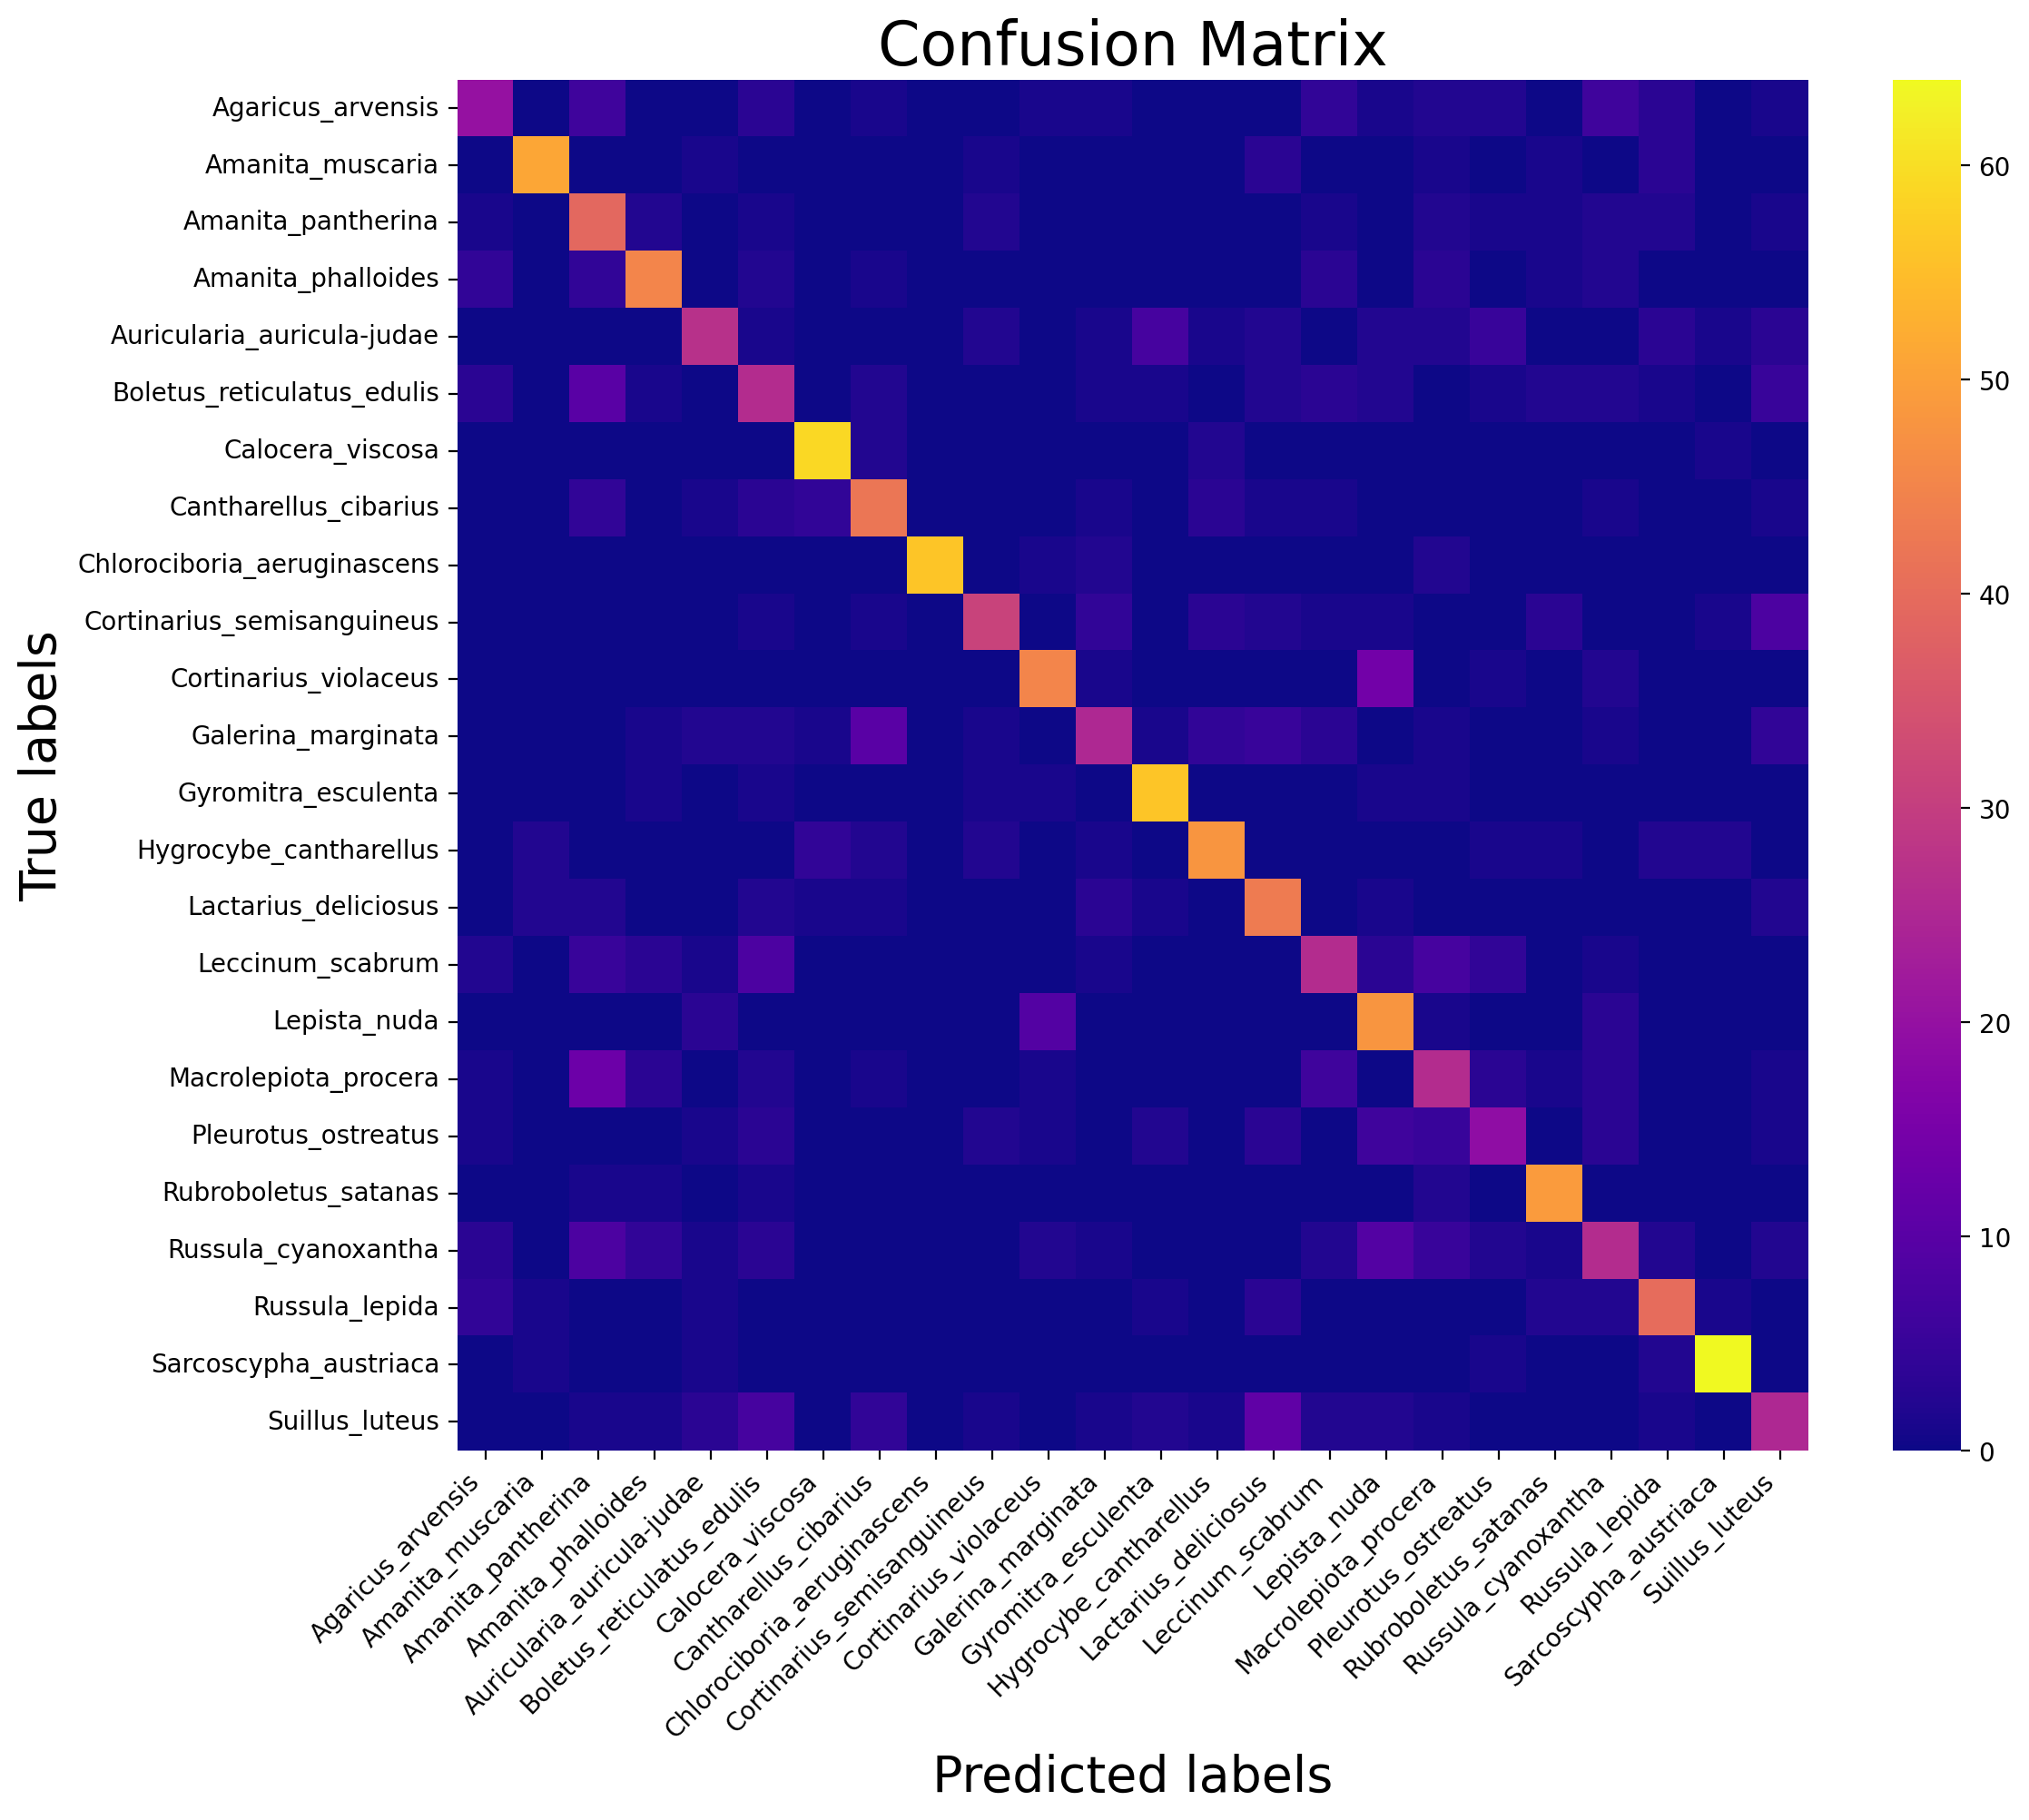

In [ ]:
import sklearn.metrics as metrics
import seaborn as sb
plt.figure(figsize=(12, 10), dpi=200, facecolor="white")
cm1 = metrics.confusion_matrix(test_generator.classes, predictions)
ax = plt.subplot()


result = sb.heatmap(cm1, ax=ax, cmap='plasma').get_figure()

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=24)
ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.set_yticklabels(labels,rotation=0)
result.savefig('savedCM_'+now+'.png')


print(labels)

print(len(test_generator.classes))
print(len(predictions))

print(metrics.classification_report(test_generator.classes, predictions, target_names=labels))
print(matthews_corrcoef(test_generator.classes, predictions))

In [ ]:
cr = metrics.classification_report(test_generator.classes, predictions, target_names=labels, output_dict=True)

In [ ]:
import pandas as pd
df = pd.DataFrame(cr).transpose()

In [ ]:
df = df.drop(['accuracy','macro avg', 'weighted avg'])


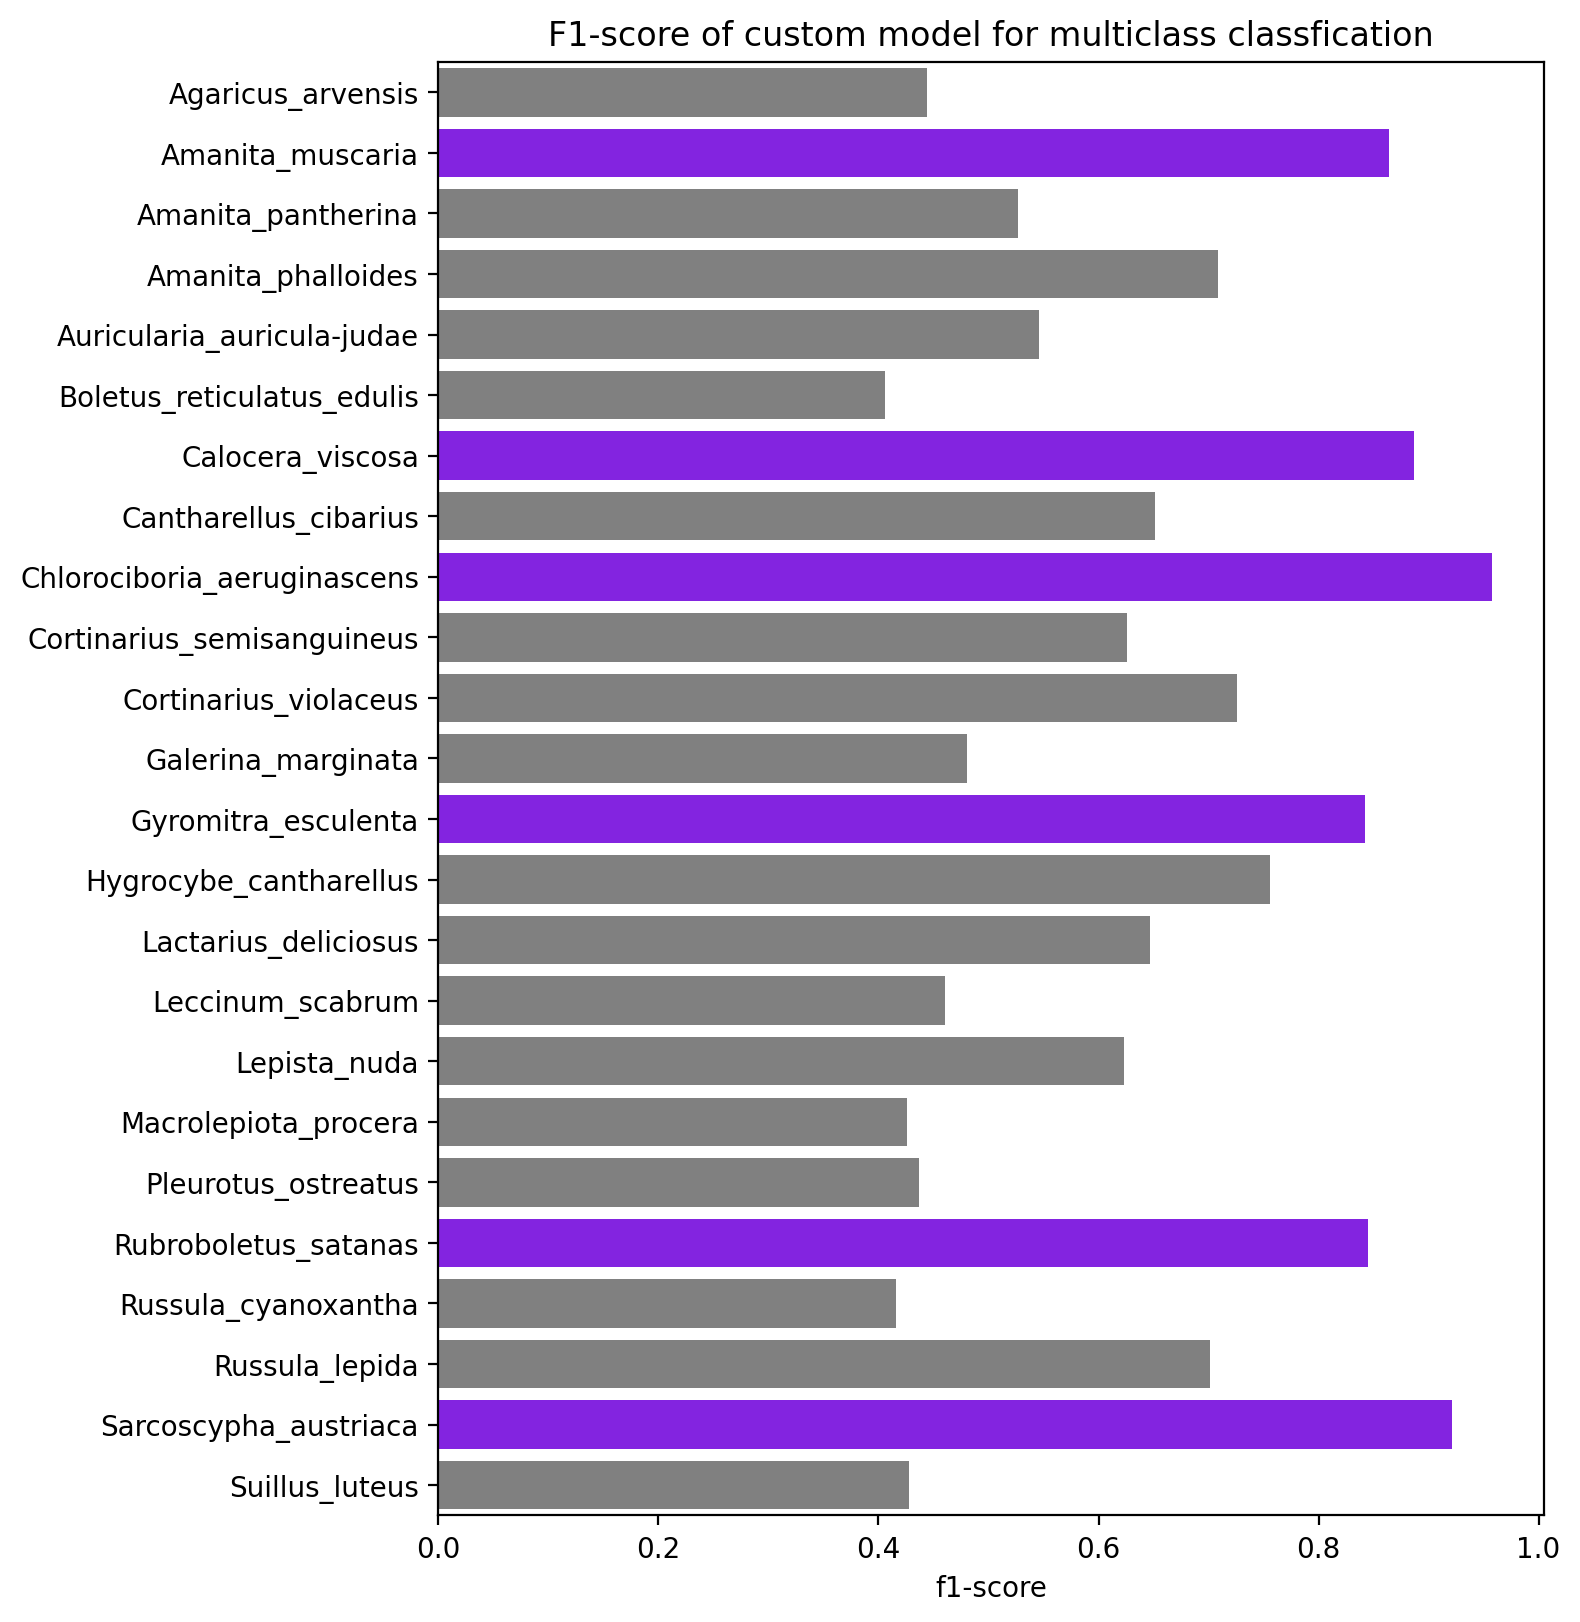

In [ ]:
import seaborn as sb
from matplotlib import rcParams

clrs = ['grey' if (x < 0.8) else '#8305FF' for x in df['f1-score'] ]
plt.figure(figsize=(8, 8), dpi=200, facecolor="white")


g = sb.barplot(y= df.index, x='f1-score', data = df,palette=clrs)
plt.tight_layout()
g.set_title("F1-score of custom model for multiclass classfication")
g.figure.savefig('classesRanking_'+now+'.png', format='png', dpi=200)


In [ ]:
df

,precision,recall,f1-score,support
Agaricus_arvensis,0.512821,0.392157,0.444444,51.0
Amanita_muscaria,0.894737,0.836066,0.864407,61.0
Amanita_pantherina,0.419355,0.709091,0.527027,55.0
Amanita_phalloides,0.725806,0.692308,0.708661,65.0
Auricularia_auricula-judae,0.642857,0.473684,0.545455,57.0
Boletus_reticulatus_edulis,0.393939,0.419355,0.406250,62.0
Calocera_viscosa,0.855072,0.921875,0.887218,64.0
Cantharellus_cibarius,0.626866,0.677419,0.651163,62.0
Chlorociboria_aeruginascens,1.000000,0.918033,0.957265,61.0
Cortinarius_semisanguineus,0.720930,0.553571,0.626263,56.0


In [ ]:
model.evaluate(train_generator)

217/217 [==============================] - 88s 404ms/step - loss: 1.0210 - accuracy: 0.6793


[1.0210065841674805, 0.679271399974823]

In [ ]:
model.evaluate(validation_generator)

74/74 [==============================] - 14s 193ms/step - loss: 1.2004 - accuracy: 0.6457


[1.2004470825195312, 0.6456908583641052]

In [ ]:
model.evaluate(test_generator)

73/73 [==============================] - 13s 181ms/step - loss: 1.1788 - accuracy: 0.6464


[1.178823709487915, 0.6464088559150696]

<Figure size 432x288 with 0 Axes>

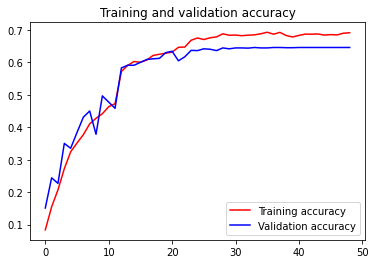

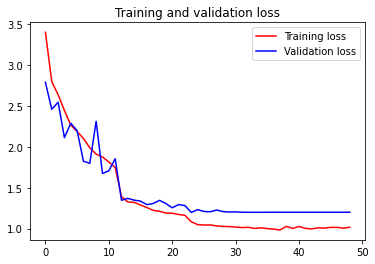

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline


acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']
epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('savedacc_'+now+'.png', dpi=200)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('savedloss_'+now+'.png', dpi=200)
plt.figure()

